<a href="https://colab.research.google.com/github/ParhamPishro/Solutions-of-FUM-Academic-Exercises/blob/main/Deep%20Learning/6_Convolution_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import requests
from skimage import io, color
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from io import BytesIO
from scipy.sparse import csr_matrix
from skimage.transform import resize

##Image Loading and Preprocessing

(100, 208)


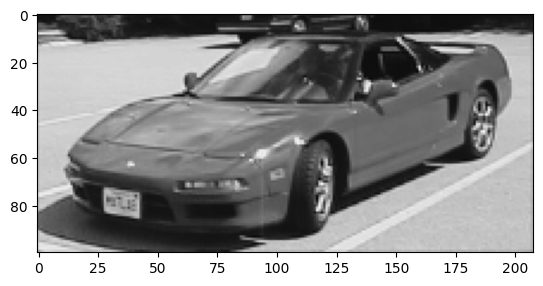

In [ ]:
img_url = "https://raw.githubusercontent.com/fum-cs/dl/master/code/images/optdeblur_01.jpg"
response = requests.get(img_url)
img = io.imread(BytesIO(response.content))
img_gray = color.rgb2gray(img)
img_gray = resize(img_gray, (100,208))

# Define dim
m, n = img_gray.shape
mn = m * n

print(img_gray.shape)
plt.imshow(img_gray, cmap='gray')

$G = D*P$

Find the original image ($x$), without having P.

$\min_x ||Dx-G||$



##Creating a sparse matrix for the Prewitt filter

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# Define horizontal Prewitt kernel
prewitt_kernel = np.array([[1, 1, 1],
                           [0, 0, 0],
                           [-1, -1, -1]])

# Function to generate sparse matrix from the given kernel
def generate_sparse_matrix(kernel, m, n):

    idx_pairs = []
    kernel_values = []
    kernel_size = kernel.shape[0]
    half_size = kernel_size // 2

    # Calculating the total number of pixels
    for row in range(m):
        for col in range(n):
            for k_row in range(kernel_size):
                for k_col in range(kernel_size):
                    # Calculating new coordinates in the image
                    new_row = row + k_row - half_size
                    new_col = col + k_col - half_size

                    if 0 <= new_row < m and 0 <= new_col < n:
                        pixel_index = row * n + col  # Current pixel index
                        kernel_index = new_row * n + new_col  # Kernel position index

                        idx_pairs.append((pixel_index, kernel_index))  # Store index pairs
                        kernel_values.append(kernel[k_row, k_col])  # Save kernel value

    # Create a sparse matrix with dimensions (mn, mn) using the calculated indices and values
    if not idx_pairs:
        raise ValueError("No valid indices found for the sparse matrix")

    row_indices, col_indices = zip(*idx_pairs)  # Separating indices into two lists
    return csr_matrix((kernel_values, (row_indices, col_indices)), shape=(mn, mn))
# Create sparse matrix for the horizontal Prewitt kernel
D_x = generate_sparse_matrix(prewitt_kernel, m, n)

# Display the result
print("D_x:", D_x.shape)

D_x: (20800, 20800)


#Edge Detection Using sparse matrix

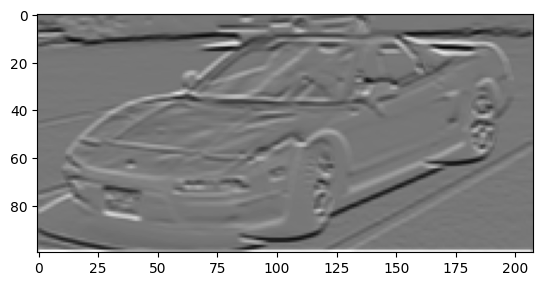

In [ ]:
# Edge extraction

G = D_x @ img_gray.flatten()
plt.imshow(G.reshape(m,n),cmap='gray')

##Defiltering Using Optimization

In [ ]:
%%time
#Classical optimization method for solving Ax-b (or Dx-G)
from scipy.optimize import lsq_linear

sol = lsq_linear(D_x, G, bounds=(0,1))
xpic = sol.x.reshape(m,n)

CPU times: user 41.9 s, sys: 34.7 s, total: 1min 16s
Wall time: 45.1 s


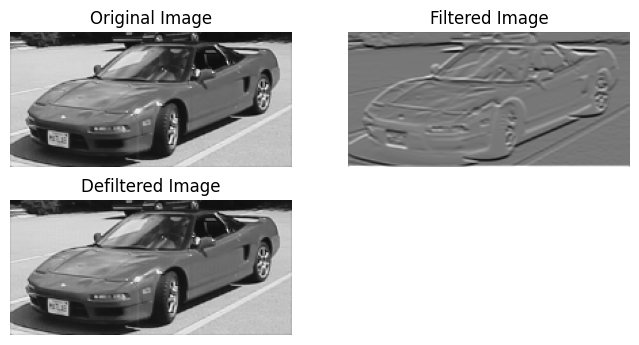

In [ ]:
fig = plt.figure(figsize=(8,4))
plt.gray()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

ax1.imshow(img_gray, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Original Image')

ax2.imshow(G.reshape(m,n))
ax2.set_axis_off()
ax2.set_title('Filtered Image')

ax3.imshow(xpic, cmap='gray')
ax3.set_axis_off()
ax3.set_title('Defiltered Image')

plt.show()

##Deep Learning Model for Kernel Estimation

In [ ]:
H, W = m, n
class ImprovedImageReconstructionModel(nn.Module):
    def __init__(self):
        super(ImprovedImageReconstructionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.relu = nn.ReLU()  # ReLU activation function
        # Calculate output size from convolution layers
        self.output_size = self._get_conv_output_size((1, 1, H, W))
        self.fc1 = nn.Linear(self.output_size, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, H * W)  # Final output layer

    def _get_conv_output_size(self, shape):
        input_tensor = torch.rand(shape)
        output = self.pool(self.relu(self.conv1(input_tensor)))
        output = self.pool(self.relu(self.conv2(output)))
        return output.numel()  # Number of elements in the output

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 1, H, W)  # Reshape back to image format

# Instantiate the model
model = ImprovedImageReconstructionModel()
model.train()

ImprovedImageReconstructionModel(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=20800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20800, bias=True)
)

In [ ]:
#Define of Kernel Prwitt
prewitt_horizontal = np.array([[1, 1, 1],
                               [0, 0, 0],
                               [-1, -1, -1]], dtype=np.float32)
# Prepare the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Convert image to Tensor
img_tensor = transform(img_gray).unsqueeze(0).float()
G_tensor = transform(G.reshape(m,n)).unsqueeze(0).float()

# Model creation and training
model = ImprovedImageReconstructionModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Model training
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(img_tensor)
    loss = criterion(output, G_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Display model weights
weights = model.conv1.weight.data.numpy().squeeze()
print("Learned weights:\n", weights)

# Using the model to predict edges
model.eval()
with torch.no_grad():
    predicted_edges = model(img_tensor)


Epoch [10/100], Loss: 1.4179
Epoch [20/100], Loss: 0.6166
Epoch [30/100], Loss: 0.2146
Epoch [40/100], Loss: 0.0795
Epoch [50/100], Loss: 0.0286
Epoch [60/100], Loss: 0.0101
Epoch [70/100], Loss: 0.0035
Epoch [80/100], Loss: 0.0012
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0001
Learned weights:
 [[[-0.23947787  0.2830047  -0.17744064]
  [ 0.15398352  0.01676704 -0.13602465]
  [ 0.19319806  0.07193536  0.076243  ]]

 [[-0.03000009  0.30165482  0.22059003]
  [ 0.21372004  0.1232517  -0.31486925]
  [-0.14997424  0.15886274  0.26091883]]

 [[-0.08340588  0.14156812  0.18549907]
  [ 0.24572116 -0.0978551  -0.30810848]
  [ 0.15528253 -0.06915097 -0.03492013]]

 [[-0.02574866  0.28848153 -0.13839982]
  [-0.17730546 -0.3140284  -0.19107708]
  [ 0.01029286 -0.1650449  -0.13252625]]

 [[-0.2521479  -0.2417129   0.01687954]
  [ 0.2649775   0.12856944  0.01840768]
  [ 0.25265095 -0.01583551 -0.23366679]]

 [[-0.13582596 -0.2619354  -0.23781876]
  [-0.07763482  0.24162203 -0.23946783]
 

Shape of model.conv1 weights: torch.Size([8, 1, 3, 3])
Shape of single_filter: torch.Size([3, 3])


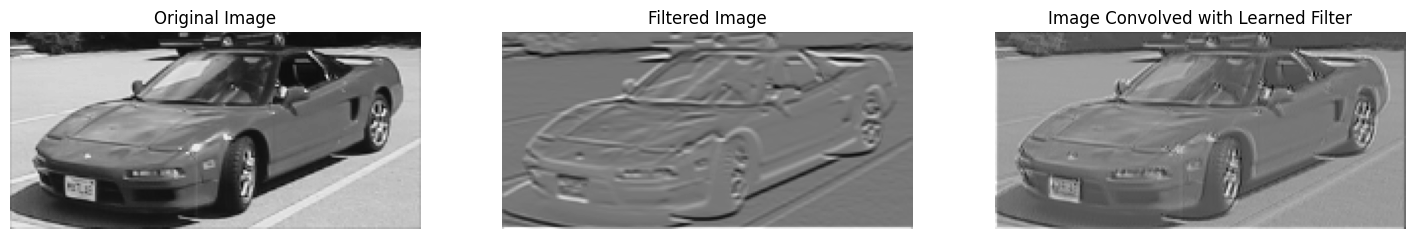

In [ ]:
# Debugging the shape of weights
weights = model.conv1.weight.data  # Extract weights from the first convolutional layer
print(f"Shape of model.conv1 weights: {weights.shape}")

# Ensure weights are 4D
if weights.ndim != 4:
    raise ValueError("weights must be a 4D array (out_channels, in_channels, kernel_height, kernel_width).")

# Extract the first filter of the first channel
single_filter = weights[0, 0]  # Shape should be (kernel_height, kernel_width)
print(f"Shape of single_filter: {single_filter.shape}")

# Ensure single_filter is 2D
if single_filter.ndim != 2:
    raise ValueError("single_filter must be a 2D array.")

# Ensure img_gray is 2D
img_gray_2d = img_gray.squeeze()
if img_gray_2d.ndim != 2:
    raise ValueError("img_gray must be a 2D array after squeezing.")

# Perform convolution using scipy.signal.convolve2d
output_with_filter = signal.convolve2d(img_gray_2d, single_filter.numpy(), mode='same', boundary='fill', fillvalue=0)

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img_gray_2d, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(G.reshape(m,n), cmap='gray')
ax[1].set_title('Filtered Image')
ax[1].axis('off')

ax[2].imshow(output_with_filter, cmap='gray')
ax[2].set_title('Image Convolved with Learned Filter')
ax[2].axis('off')

plt.show()
